In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import optuna 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, f1_score
import numpy as np

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

test_ids = test_df['id'].copy()

In [3]:
train_df

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26
749998,749998,31,68,29,Red,Cotton,9,11,12,20-20


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


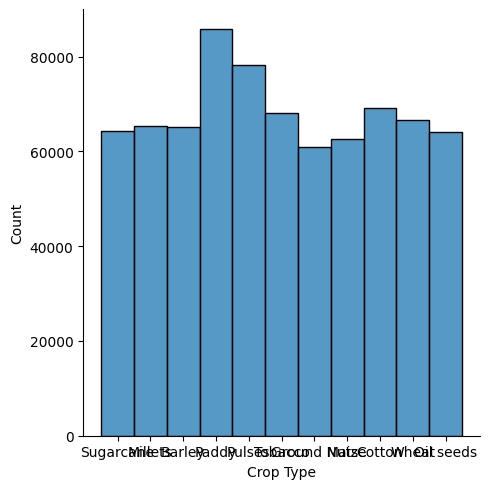

In [4]:
sns.displot(train_df['Crop Type'])

In [5]:
label_encoders = {}
categorical_cols = ['Soil Type', 'Crop Type']

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    # Apply the same encoder to the test set
    # This assumes test_df[col] does not contain categories not present in train_df[col]
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

In [6]:
le_fertilizer = LabelEncoder()
train_df['Fertilizer Name'] = le_fertilizer.fit_transform(train_df['Fertilizer Name'])

In [7]:
X = train_df.drop(['id', 'Fertilizer Name'], axis=1)
y = train_df['Fertilizer Name']

X_test = test_df.drop(['id'], axis=1)
X_test = X_test[X.columns]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [8]:
xgb_model = XGBClassifier(gamma=0.9983907428517708,
                    learning_rate=0.0824718385128289,
                    max_depth=7,
                    n_estimators=791,
                    reg_alpha=2.6733774199868625e-05,
                    reg_lambda=0.02024650847345447,
                    subsample=0.5971277479596702,
                    colsample_bytree=0.5170031254212086,
                    eval_metric='mlogloss',
                    use_label_encoder=False,
                    random_state=42,
                    objective='multi:softprob')

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5170031254212086, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.9983907428517708, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0824718385128289,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=791, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
# --- Part 1: Validation (as in original user code) ---
print("Training model on X_train for validation...")
xgb_model.fit(X_train, y_train)

# Define MAP@k function (as provided by user)
def mapk_at_k(y_true, y_pred_topk, k=3):
    """
    y_true: массив истинных меток (shape = [n_samples])
    y_pred_topk: список списков, где каждый внутренний список —
                 топ-k предсказанных меток для соответствующего примера.
                 (shape = [n_samples, k])
    k: число топ-предсказаний (по умолчанию 3).
    """
    num_samples = len(y_true)
    if num_samples == 0:
        return 0.0
    score = 0.0
    for i in range(num_samples):
        true_label = y_true[i]
        pred_labels = y_pred_topk[i] # This will be a list if y_pred_topk is a list oа lists

        if true_label in pred_labels:
            try:
                # .index() works on lists
                rank = pred_labels.index(true_label)
                score += 1.0 / (rank + 1)
            except ValueError:
                # Should not happen if 'true_label in pred_labels' is true
                pass
    return score / num_samples

# Get probability predictions for the validation set
y_val_proba = xgb_model.predict_proba(X_val)

# Get top-3 predicted class indices for validation set
# These indices correspond to the encoded labels
top3_indices_val = np.argsort(y_val_proba, axis=1)[:, ::-1][:, :3]

# Convert y_val to numpy array for the mapk_at_k function
y_val_array = y_val.to_numpy()

# Calculate MAP@3 on the validation set
# Pass top3_indices_val.tolist() so each element in y_pred_topk is a list
map3_val = mapk_at_k(
    y_true=y_val_array,
    y_pred_topk=top3_indices_val.tolist(),
    k=3
)
print(f"MAP@3 на валидационной выборке (модель обучена на X_train): {map3_val:.5f}")
print("-" * 30)

Training model on X_train for validation...
MAP@3 на валидационной выборке (модель обучена на X_train): 0.33935
------------------------------


In [10]:
# --- Part 2: Training on Full Data and Generating Submission ---
print("Training final model on the full training dataset (X, y)...")
# Retrain the same xgb_model object on the full dataset X, y
xgb_model.fit(X, y)

print("Making predictions on the test set...")
# Get probability predictions for the test set
y_test_proba = xgb_model.predict_proba(X_test)

# Get top-3 predicted class indices for the test set
top3_indices_test = np.argsort(y_test_proba, axis=1)[:, ::-1][:, :3]

print("Decoding predictions...")
# Decode the predicted class indices back to original fertilizer names
predicted_fertilizer_names_list = []
for i in range(len(top3_indices_test)):
    # top3_indices_test[i] contains the top 3 *encoded* labels
    decoded_labels = le_fertilizer.inverse_transform(top3_indices_test[i])
    predicted_fertilizer_names_list.append(" ".join(decoded_labels))

print("Creating submission file...")
# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'Fertilizer Name': predicted_fertilizer_names_list
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Training final model on the full training dataset (X, y)...
Making predictions on the test set...
Decoding predictions...
Creating submission file...
Submission file 'submission.csv' created successfully.
